# Problem Statment:
First problem (Task 1) is a binary image classification problem. The problem focuses on identifying the presence of cancerous cells from a 27*27*3 histopathology colon images.

In [23]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.models import Sequential
#from keras.applications.vgg16 import VGG16
#from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import cv2
from random import sample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil

tf.random.set_seed(101)

In [2]:
all_img_data = pd.read_csv("data_labels_mainData.csv")
all_img_path = {os.path.basename(x) : x for x in
               glob(os.path.join("./patch_images","*.png"))}
print("Images found:", len(all_img_path), ", Total Headers" , all_img_data.shape[0])
all_img_data["imagePath"] = all_img_data["ImageName"].map(all_img_path.get)
all_img_data.sample(10)

Images found: 20280 , Total Headers 9896


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,imagePath
9193,12216,55,12216.png,epithelial,2,1,./patch_images/12216.png
5587,11959,31,11959.png,epithelial,2,1,./patch_images/11959.png
3235,8510,18,8510.png,epithelial,2,1,./patch_images/8510.png
2024,15765,12,15765.png,inflammatory,1,0,./patch_images/15765.png
5354,17219,29,17219.png,inflammatory,1,0,./patch_images/17219.png
1684,13426,10,13426.png,inflammatory,1,0,./patch_images/13426.png
8401,3857,52,3857.png,epithelial,2,1,./patch_images/3857.png
2159,4521,13,4521.png,epithelial,2,1,./patch_images/4521.png
5450,11812,30,11812.png,epithelial,2,1,./patch_images/11812.png
5256,17117,29,17117.png,inflammatory,1,0,./patch_images/17117.png


In [3]:
all_img_data["CancerousClass"] = all_img_data["isCancerous"].apply(lambda x : 'Y' if x==1 else 'N')
all_img_data.sample(5)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,imagePath,CancerousClass
3947,9373,21,9373.png,epithelial,2,1,./patch_images/9373.png,Y
9321,16826,56,16826.png,fibroblast,0,0,./patch_images/16826.png,N
763,9064,7,9064.png,fibroblast,0,0,./patch_images/9064.png,N
9319,16824,56,16824.png,fibroblast,0,0,./patch_images/16824.png,N
8407,3863,52,3863.png,epithelial,2,1,./patch_images/3863.png,Y


In [4]:
all_img_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,imagePath,CancerousClass
0,22405,1,22405.png,fibroblast,0,0,./patch_images/22405.png,N
1,22406,1,22406.png,fibroblast,0,0,./patch_images/22406.png,N
2,22407,1,22407.png,fibroblast,0,0,./patch_images/22407.png,N
3,22408,1,22408.png,fibroblast,0,0,./patch_images/22408.png,N
4,22409,1,22409.png,fibroblast,0,0,./patch_images/22409.png,N


In [5]:
print(len(all_img_data[all_img_data["isCancerous"] == 1]))
print(len(all_img_data[all_img_data["isCancerous"] == 0]))

4079
5817


In [6]:
pos_idx = all_img_data[all_img_data['CancerousClass']=='Y'].index.tolist()
neg_idx = all_img_data[all_img_data['CancerousClass']=='N'].index.tolist()

In [7]:
len(pos_idx)

4079

In [8]:
len(neg_idx)

5817

In [9]:
def create_splits(**vargs):
    
    
    
    df, test_size, target_class = vargs['dataframe'], vargs['test_size'], vargs['target_class']
    
    train_df, valid_df = train_test_split(df, test_size=test_size, stratify=df[target_class])
    
    prop_train = len(train_df[train_df["CancerousClass"] == "Y"]) / len(train_df)
    prop_val = len(valid_df[valid_df["CancerousClass"] == "Y"]) / len(valid_df)
    
    
    pos_idx = train_df[train_df['CancerousClass']=='Y'].index.tolist()
    neg_idx = train_df[train_df['CancerousClass']=='N'].index.tolist()
    neg_idx = sample(neg_idx,len(pos_idx))
    train_df = train_df.loc[pos_idx+neg_idx]
    train_df_ratio = len(train_df[train_df['CancerousClass'] == 'Y'])/len(train_df)
    print(len(train_df[train_df['CancerousClass']=='Y'].index.tolist()))
    print(len(train_df[train_df['CancerousClass']=='N'].index.tolist()))
    print(f'Percentage of Positive Cancerous samples in training set: {100.0*train_df_ratio :.2f}%')
    
    
    pos_idx = valid_df[valid_df['CancerousClass'] == 'Y'].index.tolist()
    print(len(valid_df[valid_df['CancerousClass'] == 'Y'].index.tolist()))
    neg_idx = valid_df[valid_df['CancerousClass'] == 'N'].index.tolist()
    print(len(valid_df[valid_df['CancerousClass'] == 'N'].index.tolist()))
    neg_idx = sample(neg_idx,len(pos_idx))
    valid_df = valid_df.loc[pos_idx+neg_idx]
    valid_df_ratio = len(valid_df[valid_df['CancerousClass']=='Y'])/len(valid_df)
    print(f'Percentage of Positive Cancerous samples in validation set: {100.0*valid_df_ratio :.2f}%')
    print(len(valid_df[valid_df['CancerousClass'] == 'Y'].index.tolist()))
    print(len(valid_df[valid_df['CancerousClass'] == 'N'].index.tolist()))
    
    return train_df, valid_df

In [10]:
train_df , valid_df = create_splits(dataframe=all_img_data, test_size=0.2, target_class = 'CancerousClass')

3263
3263
Percentage of Positive Cancerous samples in training set: 50.00%
816
1164
Percentage of Positive Cancerous samples in validation set: 50.00%
816
816


In [11]:
print(len(train_df))
print(len(valid_df))


6526
1632


In [12]:
IMG_SIZE = (27,27)
BATCH_SIZE = 32

In [13]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1.0/255.0,
                             horizontal_flip=True,
                             vertical_flip=True,
                             #width_shift_range=0.1,
                             #height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2,
                             rotation_range=15
                            )
    
    return my_idg


def make_train_gen(**vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    
    df = vargs['dataframe']
    train_idg = my_image_augmentation()
    
    train_gen = train_idg.flow_from_dataframe(dataframe=df,
                                        directory=None,
                                        x_col='imagePath',
                                        y_col='CancerousClass',
                                        class_mode='binary',
                                        target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE
                                       )

    return train_gen


def make_val_gen(**vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    
    df = vargs['dataframe']
    
    val_idg = ImageDataGenerator(rescale=1.0/255.0)
    val_gen = val_idg.flow_from_dataframe(dataframe=df,
                                          directory=None,
                                          x_col='imagePath',
                                          y_col='CancerousClass',
                                          class_mode='binary',
                                          target_size=IMG_SIZE,
                                          batch_size=BATCH_SIZE
                                         )
    
    
    return val_gen

In [14]:
train_gen = make_train_gen(dataframe=train_df)
val_gen = make_val_gen(dataframe=valid_df)

Found 6526 validated image filenames belonging to 2 classes.
Found 1632 validated image filenames belonging to 2 classes.


In [15]:
valX, valy = val_gen.next()

In [16]:
print(f"ValX Shape: {valX.shape} and valY shape: {valy.shape}")

ValX Shape: (32, 27, 27, 3) and valY shape: (32,)


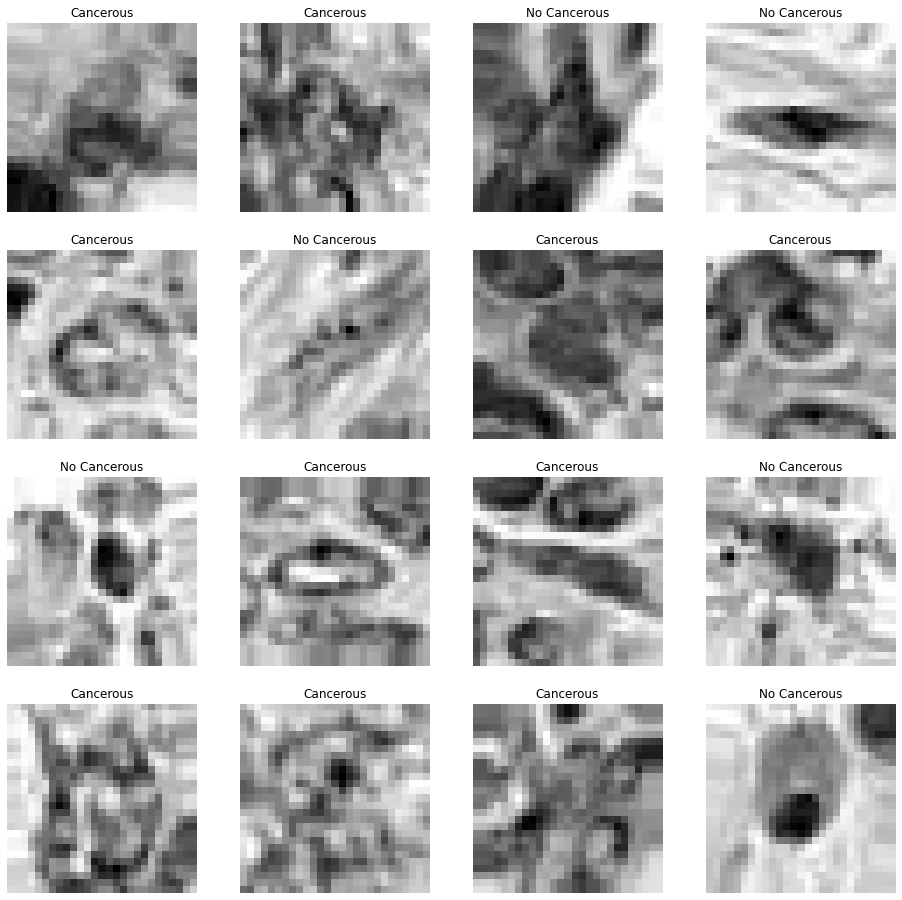

In [50]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='gray')
    if c_y == 1: 
        c_ax.set_title('Cancerous')
    else:
        c_ax.set_title('Not Cancerous')
    c_ax.axis('off')

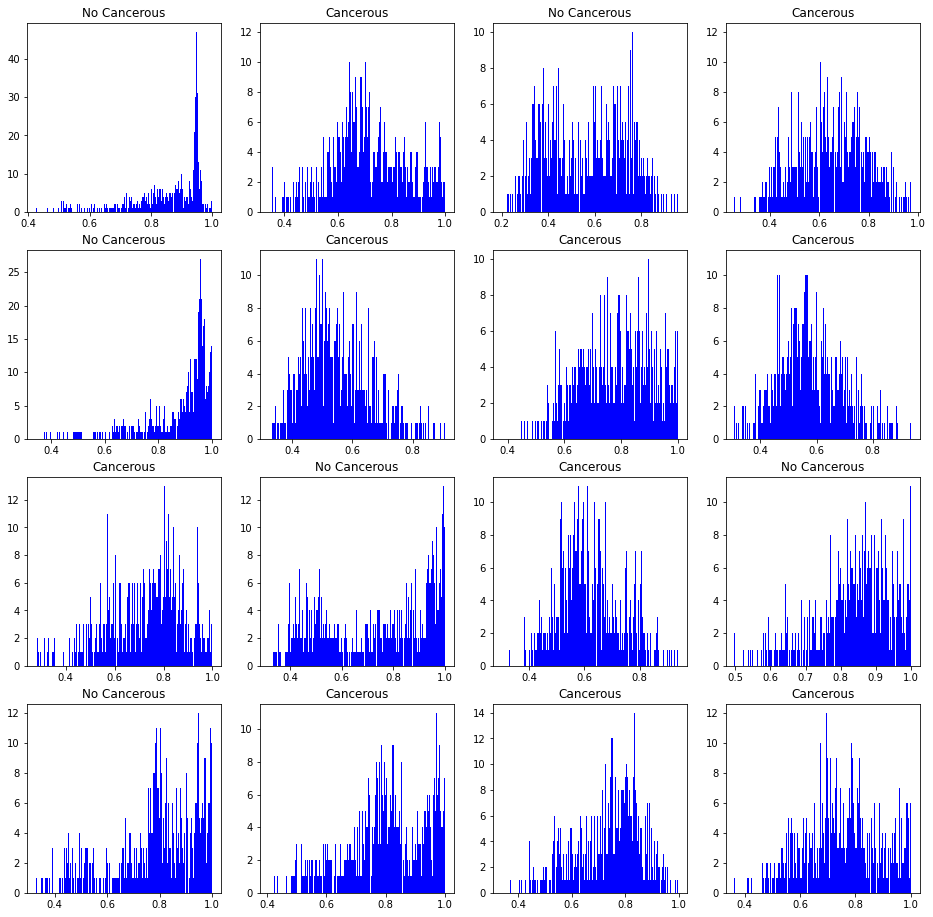

In [41]:
# t_x, t_y = next(train_gen)

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     mask = (data > 0.1) & (data < 0.9)
#     d = data[mask].flatten()
    c_ax.hist(c_x[:,:,0].flatten(), bins = 256, color='blue')
    
    if c_y == 1: 
        c_ax.set_title('Cancerous')
    else:
        c_ax.set_title('No Cancerous')

plt.show()

In [19]:
import tensorflow as tf
def my_model():
    
    reg_lambda=.001
    
    model = Sequential()
    
    model.add(Conv2D(input_shape=(27,27,3),filters=64,kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    return model
    

In [20]:
model = my_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 256)        

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [37]:
!pip install pydot

In [24]:
optimizer = SGD(0.01)#Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# define callbacks
weight_path="{}_model.best.hdf5".format('Cancerous_Classification')
checkpoint = ModelCheckpoint(weight_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=10)
callbacks_list = [checkpoint, early]

In [25]:
# train your model
history = model.fit_generator(
    train_gen, 
    validation_data = (valX, valy), 
    epochs = 100,
    verbose=1,
    callbacks = callbacks_list)

Epoch 1/100
204/204 [==============================] - 87s 424ms/step - loss: 3.0154 - binary_accuracy: 0.5069 - val_loss: 3.0055 - val_binary_accuracy: 0.5312

Epoch 00001: val_loss improved from inf to 3.00548, saving model to Cancerous_Classification_model.best.hdf5
Epoch 2/100
204/204 [==============================] - 82s 402ms/step - loss: 2.9961 - binary_accuracy: 0.5268 - val_loss: 2.9869 - val_binary_accuracy: 0.4688

Epoch 00002: val_loss improved from 3.00548 to 2.98691, saving model to Cancerous_Classification_model.best.hdf5
Epoch 3/100
204/204 [==============================] - 83s 405ms/step - loss: 2.9768 - binary_accuracy: 0.5588 - val_loss: 2.9667 - val_binary_accuracy: 0.5938

Epoch 00003: val_loss improved from 2.98691 to 2.96666, saving model to Cancerous_Classification_model.best.hdf5
Epoch 4/100
204/204 [==============================] - 85s 415ms/step - loss: 2.9570 - binary_accuracy: 0.6195 - val_loss: 2.9471 - val_binary_accuracy: 0.6562

Epoch 00004: val_loss

In [32]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 3ms/step


In [27]:
def plot_history(history):
    
    f = plt.figure()
    f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()

    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
    plt.plot(history.history['binary_accuracy'], label='train accuracy')
    plt.legend()

    plt.show()

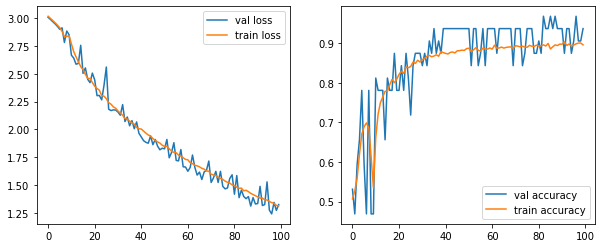

In [28]:
plot_history(history)

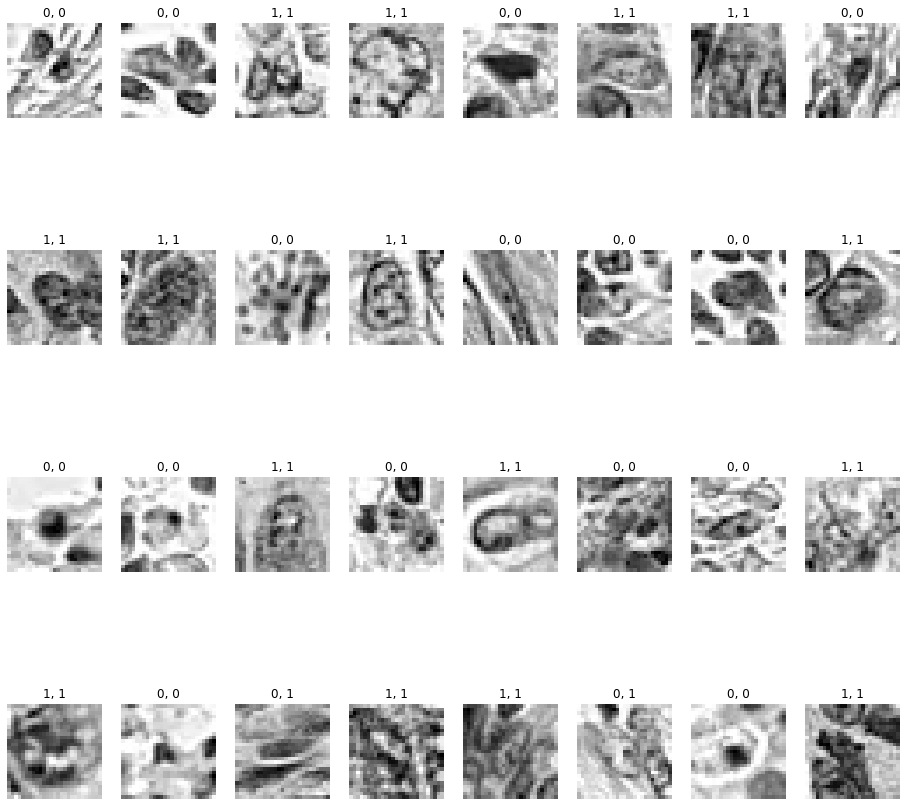

In [33]:
threshold = 0.4

fig, m_axs = plt.subplots(4, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valy[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='gray')
    if c_y == 1: 
        if pred_Y[i] > threshold :
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold : 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

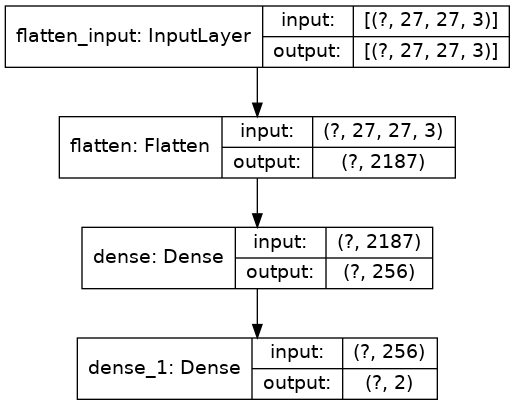

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)